In [2]:
import numpy as np
import matplotlib as plt
from scipy.integrate import odeint
from pylab import *
from scipy import signal
from scipy.signal import argrelextrema
import pandas as pd
import seaborn as sns
df = pd.read_csv('ks_vs_periods.csv')
def reduce_ks_by_period(df, period_list):
    index_list = []
    for x in period_list:
        difference = np.abs(df.period - x)
        index_min_diff = np.argmin(difference)
        index_list.append(index_min_diff)
    reduced_df =  df.iloc[index_list]   
    return(reduced_df)  

#test_list = reduce_ks_by_period(df, [32., 30., 28., 26., 24., 22., 20., 18.])
test_list = reduce_ks_by_period(df, [32., 31., 30., 29., 28., 27., 26., 25., 24., 23., 22., 21., 20., 19., 18.])
test_list.to_csv('ks_vs_periods_reduced.csv')
test_list

,Unnamed: 0,ks,period
1,1,0.0825,32.127677
6,6,0.0950,30.985915
27,27,0.1475,30.002500
40,40,0.1800,29.002417
53,53,0.2125,27.968997
66,66,0.2450,26.977248
80,80,0.2800,26.002167
96,96,0.3200,24.977081
113,113,0.3625,24.002000
133,133,0.4125,22.989416


light_amp_list [0.08]
light_period_list [23, 25]
<function df at 0x000002216B951040>
1.0 0.2000000000000001
vs, ks, light_period =  1.0 0.2000000000000001 23


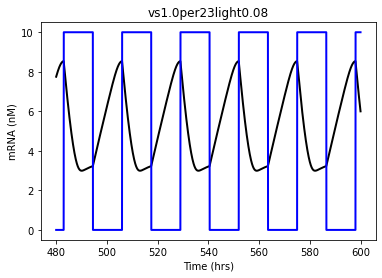

Entrained? Press y if yes, or any other key if no, then Enter
y
Received yes input

vs, ks, light_period =  1.0 0.2000000000000001 25


<Figure size 360x216 with 0 Axes>

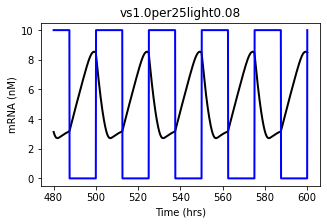

In [ ]:
"""
Model of circadian oscillator with entraiment
"""
import numpy as np
import matplotlib as plt
from scipy.integrate import odeint
from pylab import *
from scipy import signal
from scipy.signal import argrelextrema
import pandas as pd
import seaborn as sns
import msvcrt

def hill_up(x, k, n):
    h = np.power(x,n)/(np.power(k,n) + np.power(x,n))
    return h
    
def hill_down(x, k, n):
    h = np.power(k,n)/(np.power(k,n) + np.power(x,n))
    return h

def square_wave(t, period, amp):
    wave = amp*signal.square(2 * np.pi * t/period)+amp
    return wave
            
# solve the system dy/dt = f(y, t)
def df(y, t):
    #assign input vector,y to variables of the model
    M  = y[0]
    PC = y[1]
    PN = y[2]

    # mRNA expression hill_down(x, k, n)
    dM =  vs*hill_down(PN, KI, 4) - vm*hill_up(M, Km, 1) - square_wave(t, light_period, light_amp)*M
    # Protein concentration, PC - celllular, PN - nuclear
    dPC =   ks*M + k2*PN - k1*PC    - vd*hill_up(PC, Kd, 1)
    dPN =        - k2*PN + k1*PC
    # output right-hand side of differetial equations
    return [dM, dPC, dPN]

def find_peaks(t,v):
    # convert voltage trace into array
    v_array = np.array(v, dtype=float)
    # Find indices of local max(spikes)
    locs_max = argrelextrema(v_array, np.greater, order=2)[0]
    # Record spike times and max voltages in a dataframe
    peak_times = t[locs_max]
    peak_amp   = v[locs_max]
    return(peak_times, peak_amp)

def find_troughs(t,v):
    # convert voltage trace into array
    v_array = np.array(v, dtype=float)
    # Find indices of local max(spikes)
    locs_min = argrelextrema(v_array, np.less, order=2)[0]
    # Record spike times and max voltages in a dataframe
    trough_times = t[locs_min]
    trough_amp   = v[locs_min]
    return(trough_times, trough_amp)
    
def pct_diff_avg_period(peaks_or_troughs,period):
    pt_avg = np.diff(peaks_or_troughs).mean()
    pct_diff = (pt_avg - period)/period*100
    return pct_diff 

def pct_norm_std_period(peaks_or_troughs):
    pt_avg = np.diff(peaks_or_troughs).mean()
    pt_std = np.diff(peaks_or_troughs).std()
    pct_norm_std = pt_std/pt_avg*100
    return pct_norm_std

def pct_norm_std_amp(amp):
    amp_avg = amp.mean()
    amp_std = amp.std()
    pct_norm_std_amp = amp_std/amp_avg*100
    return pct_norm_std_amp  

#----------------------------------------------------------------------------------------------
#   Delete all peaks not within 1.0 % of the highest peak (to eliminate multiple peaks per period)
#----------------------------------------------------------------------------------------------
def trim_peaks(peaks1,amp_peaks1):
        amp_max = amp_peaks1.max()
        mask = np.where(amp_peaks1 < 0.99*amp_max)
        peaks_trimmed1 = np.delete(peaks1,mask)
        amp_peaks_trimmed1 = np.delete(amp_peaks1,mask)
        return [peaks_trimmed1, amp_peaks_trimmed1]
    
#----------------------------------------------------------------------------------------------
#   Delete all troughs not within 1.0 % of the lowest trough (to eliminate multiple troughs per period)
#----------------------------------------------------------------------------------------------
def trim_troughs(troughs1,amp_troughs1):
        trough_min = amp_troughs1.min()
        mask = np.where(amp_troughs1 > 1.01*trough_min)
        troughs_trimmed1 = np.delete(troughs1,mask)
        amp_troughs_trimmed1 = np.delete(amp_troughs1,mask)
        return [troughs_trimmed1, amp_troughs_trimmed1]   

#-----------------------------------------------------------------------------------------------
#   Given peaks and their amplitude, as well as period of entrainmnent, decide if the trace is entrained
#-----------------------------------------------------------------------------------------------
def entrainment_boolean(peaks, peaks_amp, troughs, troughs_amp, period):
        # Choose cut off value for entrainment decision: if all three metric below cutoff, then entrained
        cutoff = 0.5
        # Calculate entrainment metrics
        pd_avg_metric_peaks  = abs(pct_diff_avg_period(peaks,period))
        pd_std_metric_peaks  = abs(pct_norm_std_period(peaks))
        amp_std_metric_peaks = abs(pct_norm_std_amp(peaks_amp))
        pd_avg_metric_troughs  = abs(pct_diff_avg_period(troughs,period))
        pd_std_metric_troughs  = abs(pct_norm_std_period(troughs))
        amp_std_metric_troughs = abs(pct_norm_std_amp(troughs_amp))
        # Introduce condition for each metric
        pd_avg_cond_peaks = (pd_avg_metric_peaks < cutoff) or (amp_peaks.any == 0.0) 
        pd_std_cond_peaks = (pd_std_metric_peaks < cutoff)
        amp_std_cond_peaks = (amp_std_metric_peaks < cutoff)
        pd_avg_cond_troughs = (pd_avg_metric_troughs < cutoff) or (amp_troughs.any == 0.0) 
        pd_std_cond_troughs = (pd_std_metric_troughs < cutoff)
        amp_std_cond_troughs = (amp_std_metric_troughs < cutoff)        
        # Return True if all conditions are satisfy, and False if even one of them are not satisfied
        cond_peaks = (pd_avg_cond_peaks and pd_std_cond_peaks and amp_std_cond_peaks)
        cond_troughs = (pd_avg_cond_troughs and pd_std_cond_troughs and amp_std_cond_troughs)
        if (cond_peaks and cond_troughs):
            entrain_flag = True
        else:
            entrain_flag = False
        return(entrain_flag)
#-----------------------------------------------------------------------------------------------
# Generate etnrainment curve using boolean entrainment matrix df
# For each entrainment period(columns) return min amount of light(idex) which lead to entrainment
#-----------------------------------------------------------------------------------------------
def entrainment_curve(df):
    # Prepare list to record entrained periods and min light intensity for those periods
    entrained_periods   = []
    min_entrained_light = []
    # Run through column and record index for first True value
    for period in df.columns:
        # Find indices of all true values in a column
        entrained_indices = np.where(df[period])[0]
        # If at least one True value in a column, record first index with a True value
        if len(entrained_indices)>0:
            min_entrained_light.append(df.index[entrained_indices[0]])
            entrained_periods.append(period)
    return(entrained_periods, min_entrained_light)

#-----------------------------------------------------------------------------------------------
#   Make a dataframe with oscillator description, such as type and color it would be plotted
#    The index of the dataframe contain parameter vaule of an oscillator
#-----------------------------------------------------------------------------------------------
def oscillator_summary():
    vs_list   = [1.0  , 1.6   ]
    vs_names  = ['Weak','Strong']
    vs_colors = ['b', 'r']
    df = pd.DataFrame(zip(vs_names, vs_colors), columns =[ 'type', 'color'], index = vs_list)
    return(df)

#-----------------------------------------------------------------------------------------------
#   Take user-defined list of desired period and find the value of ks which gives period closest to desied
#-----------------------------------------------------------------------------------------------
def match_periods(ks_full_list, periods_full_list, periods_desired):
    periods_full = np.array(periods_full_list)
    ks_full      = np.array(     ks_full_list)
    index_list = []
    for x in periods_desired:
        difference = np.abs(np.array(periods_full_list) - x)
        index_min_diff = np.argmin(difference)
        index_list.append(index_min_diff)  
    ks_reduced      = ks_full     [index_list]
    periods_reduced = periods_full[index_list]
    
    return(ks_reduced, periods_reduced) 


# Choose total time of simulation, T
T = 600.
# Chose trainsients time
T_transients = 480

# Chose time step
dt=0.05

#Calculate number of time steps
nsteps=int(T/dt)

# Calculate number of indices in transient part
trans_ind = int(T_transients/dt)

# Create time grid
t  = np.linspace(0, T, nsteps) 


# Choose initial conditions
M0  = 0.89009363    
PC0 = 0.83699889
PN0 = 1.25723695
y0= [2.1740351,  3.22519908, 3.13304933]  

# Paramters of the model
#vs = 1.6
# For weak, medium and strong oscillators, choose vs=[0.75, 1, 1.25]
#vs = 1.
vm = 0.505
Km = 0.5
KI = 1.0
#ks = 0.3
vd = 1.4
Kd = 0.13
k1 = 0.5
k2 = 0.6

vs_df = oscillator_summary()
#light_amp_list    = np.arange(0.10, 0.11, 0.01).tolist()
light_amp_list    = np.arange(0.08, 0.09, 0.01).tolist()
light_period_list = np.arange(23,26,2).tolist()
#light_period_list = np.arange(18,31,1).tolist()
print('light_amp_list', light_amp_list)
print('light_period_list',light_period_list)

entr_boolean_list_dfs = []
for vs in vs_df.index:
    df_protocol= pd.read_csv(vs_df.type[vs]+'_periods_ks.csv', index_col = 0)
    print(df)
    df_entr = pd.DataFrame([], columns = light_period_list , index= light_amp_list)
    ks = df_protocol.ks[24]
    print(vs,ks)
    
    for light_period in light_period_list:
        print('vs, ks, light_period = ',vs,ks,light_period)
        entr_boolean_list = []
        for light_amp in light_amp_list:
            # Solve ODE and plot mRNA concentraion, M
            soln = odeint(df, y0, t)
            M  = soln[trans_ind:, 0]
            PC = soln[trans_ind:, 1]
            time = t[trans_ind:]
            plot_amplitude = 5.0
            sqrwv = square_wave(time, light_period, plot_amplitude)
            plt.figure()
            plt.rcParams['figure.figsize'] = [5, 3]
            labelstring = 'vs'+str(vs)+'per'+str(light_period)+'light'+str(light_amp)
            plt.plot(time,M,'k',label=labelstring,linewidth=2)
            plt.plot(time,sqrwv,'b',linewidth=2)
            plt.xlabel('Time (hrs)')
            plt.ylabel('mRNA (nM)')
            plt.title(labelstring)
            plt.show()
            ent_flag = False
            response = input('Entrained? Press y if yes, or any other key if no, then Enter\n')
            if response.upper() == 'Y': 
                print("Received yes input\n")
                ent_flag = True
            else:
                print("Received no input\n")
            plt.clf()
            entr_boolean_list.append(ent_flag)
        df_entr[light_period] = entr_boolean_list
    entr_boolean_list_dfs.append(df_entr)
print(entr_boolean_list_dfs[0])
print(entr_boolean_list_dfs[1])
#ebld_len = len(entr_boolean_list_dfs)
#for i in range(ebld_len):
for vs in vs_df.index:
    i = vs_df.index.get_loc(vs)
    print('vs = ',vs,', loc = ',i)
    df_entr = entr_boolean_list_dfs[i]
    print(df_entr)
    df_entr.to_csv(vs_df.type[vs]+'_varylp_entr.csv', index=True)  # varying light entrainment period
    [entr_periods, entr_lights] = entrainment_curve(df_entr)
    plt.plot(entr_periods, entr_lights, vs_df.color[vs], label = vs_df.type[vs], linewidth=2)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(top=0.15)
    ax = plt.gca()
    xticks = ax.xaxis.get_major_ticks() 
    xticks[0].label1.set_visible(False)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    plt.xlabel("Entraining period (hr)",fontsize=14)
    plt.ylabel("Min light to entrain (hr$^{-1}$)",fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
#plt.plot([28], [0.05], 'k.', markersize=20.0)
#plt.text(29,0.02,'ENT',color='b',fontsize=14)
#plt.text(29,0.05,'ENT',color='g',fontsize=14)
#plt.text(26,0.12,'ENT',color='r',fontsize=14)
#plt.savefig("New-twigs-vary-lp-by-eye.jpeg", dpi = 300)
plt.show()